In [54]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
def starbattle_generator(S, N, n_attempts=0, n_fails=0):
    Stot = S*N
    r = 1
    success = False
    coord_grid = np.arange(N*N)
    good_coords = np.zeros((Stot,2), dtype=int)
    #n_attempts = 0
    while not success:
        n_attempts += 1
        coord_grid = np.arange(N*N)
        np.random.shuffle(coord_grid)
        coord_grid = np.array([(i//N,i%N) for i in coord_grid])
        stars = np.zeros((N,N), dtype=int)
        n_placed_stars = 0
        for coord in coord_grid:
            row = np.sum(stars[coord[0]])
            col = np.sum(stars[:,coord[1]])
            rl = max(coord[0]-r, 0)
            rh = min(coord[0]+r+1, N)
            cl = max(coord[1]-r, 0)
            ch = min(coord[1]+r+1, N)
            reg = np.sum(stars[rl:rh, cl:ch])
            if (row<S) and (col<S) and (reg == 0):
                #print(row, col, reg)
                stars[tuple(coord)] = 1
                good_coords[n_placed_stars,:] = coord
                n_placed_stars += 1
                if n_placed_stars == Stot:
                    success = True
                    #print(star, n_attempts)
                    break
            else:
                continue
    grid = np.zeros((N*N), dtype=int)
    for n in range(N*N):
        n_coord = (n//N, n%N)
        best_dist = 2*N
        for ind, star in enumerate(good_coords):
            dist = (n_coord[0]-star[0])**2 + (n_coord[1] - star[1])**2
            if best_dist > dist:
                best_dist = dist
                grid[n] = ind
    grid = grid.reshape(N,N)
    nn = grid.max()
    tmp = np.zeros((nn+1, nn+1), bool)

    # check the vertical adjacency
    a, b = grid[:-1, :], grid[1:, :]
    tmp[a[a!=b], b[a!=b]] = True

    # check the horizontal adjacency
    a, b = grid[:, :-1], grid[:, 1:]
    tmp[a[a!=b], b[a!=b]] = True

    # register adjacency in both directions (up, down) and (left,right)
    result = (tmp | tmp.T).astype(int)
    neighs = [[ii, list(np.flatnonzero(row))] for ii, row in enumerate(result)]
    neighs = sorted(neighs, key=lambda x: len(x[1]))
    if len(neighs[0][1]) < S-1:
        return starbattle_generator(S, N, n_attempts=n_attempts, n_fails=n_fails)
    failed = True
    new_fails = 0
    while failed:
        neighbors = neighs[:]
        #display(neighbors)
        regs = []
        reg_size = 0
        while reg_size < N:
            if len(neighbors[0][1]) < S-1:
                failed = True
                new_fails += 1
                break
            cand = np.random.choice(neighbors[0][1], S-1, replace=False)
            cand = [neighbors[0][0], *cand]
            regs.append(cand)
            #print(regs, cand)
            reg_size += 1
            n2 = neighbors[:]
            to_del = []
            for ind, neigh in enumerate(neighbors):
                #print(ind, neigh)
                if neigh[0] in cand:
                    to_del += [ind]
                else:
                    for el in cand:
                        if el in neigh[1]:
                            n2[ind][1].remove(el)
            for el in reversed(to_del):
                del n2[el]
            neighbors = n2
            failed = False
        if new_fails > 3:
            return starbattle_generator(S, N, n_attempts=n_attempts, n_fails=n_fails+new_fails)
    print("It took {} attempt(s) to generate the stars.".format(n_attempts))
    print("It took {} attempt(s) to generate the regions.".format(n_fails+1))
    #display(neighbors,regs)
    if S!=1:
        for ind, reg in enumerate(regs):
            grid[grid == reg[0]] = -ind-1
            grid[grid == reg[1]] = -ind-1
        grid = -grid-1
    return grid, stars, neighs

In [13]:
N = 10
S = 2
grid, stars, neighbors = starbattle_generator(S,N)
display(grid, stars)

It took 966 attempt(s) to generate the stars.
It took 5 attempt(s) to generate the regions.


array([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [6, 6, 1, 1, 0, 0, 0, 0, 4, 4],
       [6, 6, 6, 6, 6, 0, 0, 4, 4, 4],
       [6, 6, 6, 6, 6, 9, 9, 8, 4, 4],
       [7, 7, 6, 6, 9, 9, 8, 8, 8, 4],
       [7, 7, 7, 9, 9, 9, 8, 8, 8, 4],
       [7, 7, 7, 7, 5, 5, 3, 8, 8, 8],
       [2, 2, 2, 5, 5, 5, 3, 3, 8, 8],
       [2, 2, 2, 2, 5, 5, 3, 3, 3, 3],
       [2, 2, 2, 2, 5, 5, 5, 5, 3, 3]])

array([[0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 1]])

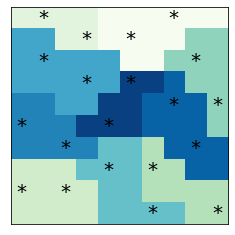

In [14]:
def draw_puzzle(grid,star):
    fig, ax = plt.subplots()
    mat = ax.imshow(grid, cmap='GnBu', interpolation='nearest')
    for x in range(star.shape[0]):
        for y in range(star.shape[1]):
            if star[x,y] == 1:
                ax.annotate("*", xy=(y, x), horizontalalignment='center', verticalalignment='center',size=20)
    plt.xticks([])
    plt.yticks([])
    plt.show()

draw_puzzle(grid,stars)